In [23]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import statsmodels.tsa.arima_process as smtsa
import statsmodels.tsa.arima_model as smmodel
import statsmodels.graphics.tsaplots as tsaplots
import statsmodels.graphics.gofplots as gofplots
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.statespace.sarimax as sarimax

In [4]:
djia_df = pd.read_excel('datasets/DJIA_Jan2016_Dec2016.xlsx')
djia_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-01-04,17405.480469,17405.480469,16957.630859,17148.939453,17148.939453,148060000
1,2016-01-05,17147.500000,17195.839844,17038.609375,17158.660156,17158.660156,105750000
2,2016-01-06,17154.830078,17154.830078,16817.619141,16906.509766,16906.509766,120250000
3,2016-01-07,16888.359375,16888.359375,16463.630859,16514.099609,16514.099609,176240000
4,2016-01-08,16519.169922,16651.890625,16314.570313,16346.450195,16346.450195,141850000


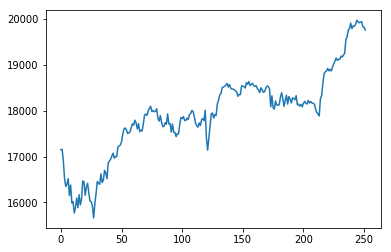

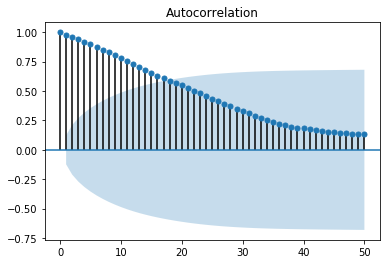

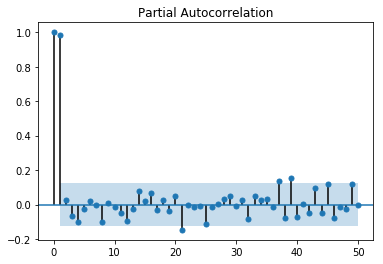

In [5]:
plt.plot(djia_df['Close'])
t1 = tsaplots.plot_acf(djia_df['Close'], lags=50)
t2 = tsaplots.plot_pacf(djia_df['Close'], lags=50)

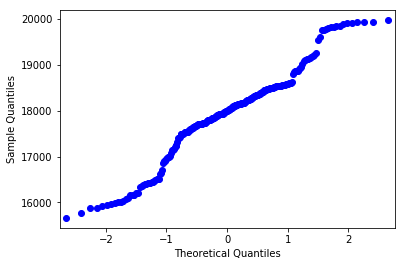

In [6]:
g0 = gofplots.qqplot(djia_df['Close'])

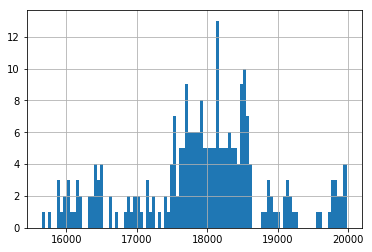

In [7]:
hist = djia_df['Close'].hist(bins=100)

In [9]:
mean1, mean2 = djia_df.iloc[:125].Close.mean(), djia_df.iloc[125:].Close.mean()
var1, var2 = djia_df.iloc[:125].Close.var(), djia_df.iloc[125:].Close.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=17226.579164, mean2=18616.603593
variance1=487045.734003, variance2=325183.639530


In [11]:
# ADF Test
adf_result= adfuller(djia_df.Close.tolist())
print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])

ADF Statistic: -0.462320
p-value: 0.899162


Text(0.5, 1.0, 'First-order differences of DJIA during Jan 2016-Dec 2016')

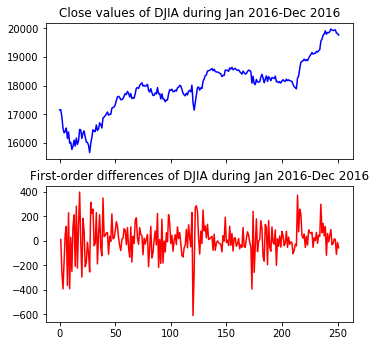

In [12]:
#Let us plot the original time series and first-differences
first_order_diff = djia_df['Close'].diff(1)
fig, ax = plt.subplots(2, sharex=True)
fig.set_size_inches(5.5, 5.5)
djia_df['Close'].plot(ax=ax[0], color='b')
ax[0].set_title('Close values of DJIA during Jan 2016-Dec 2016')
first_order_diff.plot(ax=ax[1], color='r')
ax[1].set_title('First-order differences of DJIA during Jan 2016-Dec 2016')

In [18]:
# Optimize ARMA parameters
aicVal=[]
for d in range(1,3):
    for ari in range(0, 3):
        for maj in range(0,3):
            try:
                arima_obj = smmodel.ARIMA(djia_df['Close'].tolist(),order=(ari,d,maj))
                arima_obj_fit = arima_obj.fit()
                aicVal.append([ari, d, maj, arima_obj_fit.aic])
            except ValueError:
                pass


In [19]:
# Evaluating fit using optimal parameter
arima_obj = smmodel.ARIMA(djia_df['Close'].tolist(), order=(0,2,1))
arima_obj_fit = arima_obj.fit(disp=0)
arima_obj_fit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                   D2.y   No. Observations:                  250
Model:                 ARIMA(0, 2, 1)   Log Likelihood               -1585.885
Method:                       css-mle   S.D. of innovations            136.122
Date:                Thu, 28 Mar 2019   AIC                           3177.769
Time:                        12:46:25   BIC                           3188.334
Sample:                             2   HQIC                          3182.021
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1011      0.119      0.853      0.395      -0.131       0.334
ma.L1.D2.y    -1.0000      0.012    -81.004      0.000      -1.024      -0.976
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

In [20]:
# Evaluate prediction
pred=np.append([0,0],arima_obj_fit.fittedvalues.tolist())
djia_df['ARIMA']=pred
diffval=np.append([0,0], arima_obj_fit.resid+arima_obj_fit.fittedvalues)
djia_df['diffval']=diffval

Text(0, 0.5, 'Closing price')

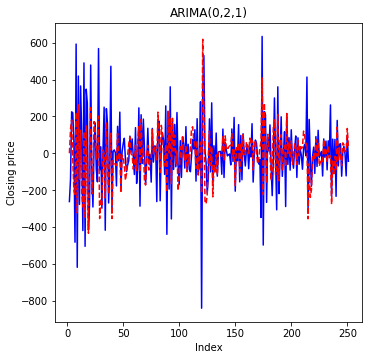

In [21]:
# Plot the curves
f, axarr = plt.subplots(1, sharex=True)
f.set_size_inches(5.5, 5.5)
djia_df['diffval'].iloc[2:].plot(color='b', linestyle = '-', ax=axarr)
djia_df['ARIMA'].iloc[2:].plot(color='r', linestyle = '--', ax=axarr)
axarr.set_title('ARIMA(0,2,1)')
plt.xlabel('Index')
plt.ylabel('Closing price')

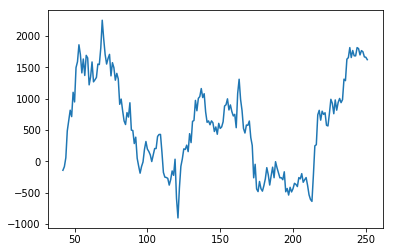

In [22]:
# Seasonality (based on first difference ACF shows significance at 42 lag)
x=djia_df['Close']-djia_df['Close'].shift(42)
x.plot()

In [24]:
mod = sarimax.SARIMAX(djia_df['Close'], trend='n', order=(0,2,1),
seasonal_order=(1,1,1,42))
sarimax= mod.fit()
sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              Close   No. Observations:                  252
Model:             SARIMAX(0, 2, 1)x(1, 1, 1, 42)   Log Likelihood               -1366.570
Date:                            Thu, 28 Mar 2019   AIC                           2741.141
Time:                                    12:49:45   BIC                           2754.491
Sample:                                         0   HQIC                          2746.539
                                            - 252                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.0000     16.163     -0.062      0.951     -32.678      30.678
ar.S.L42      -0.2542      0.093     -2.727      0.006      -0.437      -0.072
ma.S.L42      -0.4671      0.130     -3.597      0.000      -0.722      -0.213
sigma2      2.355e+04    3.8e+05      0.062      0.951   -7.22e+05    7.69e+05
===================================================================================
Ljung-Box (Q):                       31.80   Jarque-Bera (JB):                21.28
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):               0.41   Skew:                            -0.24
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Text(0, 0.5, 'Forecasted value')

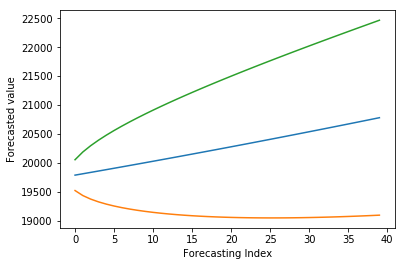

In [25]:
# Forecasting and CI
f, err, ci=arima_obj_fit.forecast(40)
plt.plot(f)
plt.plot(ci)
plt.xlabel('Forecasting Index')
plt.ylabel('Forecasted value')